# **Install JAVA8 and elephas for running distributed deep learning models with Spark**

In [3]:
# get JAVA8 for PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# install elephas library for running distributed deep learning models at scale with Spark
!pip install elephas

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
     |████████████████████████████████| 217.8MB 71kB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=863d7a42aea77f97a47a23eca74c3c402d14f8a77897fa4457f5937c8a5ed82c
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [4]:
#Check Java version.  
! java -version

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)


In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark import SparkContext, SparkConf
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

# initiatw Spark context
conf = SparkConf().setAppName('lstm').setMaster('local[4]')
sc = SparkContext(conf=conf)

Using TensorFlow backend.


WARNING


# **Data Preprocessing**

In [6]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras import metrics
import os

# set seeds
np.random.seed(666)  

# read in time series data 
df = pd.read_csv('/content/drive/My Drive/CSE6250 2020 Spring Project/mp_data/mp_lstm.csv')
print(df.shape)
df.head()

features = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'spo2']

# function to calculate the percentage of NaN in one patient for a specific feature    
def NaN_percent (x):
  return  sum(np.isnan(x).values)/len(x)

# get the percentage of NaN in one patient for a specific feature 
heartrate = pd.DataFrame(df.groupby('icustay_id')['heartrate'].apply(lambda x:NaN_percent(x))).reset_index()
sysbp = pd.DataFrame(df.groupby('icustay_id')['sysbp'].apply(lambda x:NaN_percent(x))).reset_index()
diasbp = pd.DataFrame(df.groupby('icustay_id')['diasbp'].apply(lambda x:NaN_percent(x))).reset_index()
meanbp = pd.DataFrame(df.groupby('icustay_id')['meanbp'].apply(lambda x:NaN_percent(x))).reset_index()
resprate = pd.DataFrame(df.groupby('icustay_id')['resprate'].apply(lambda x:NaN_percent(x))).reset_index()
spo2 = pd.DataFrame(df.groupby('icustay_id')['spo2'].apply(lambda x:NaN_percent(x))).reset_index()

#  filter out features which has more than 30% NaN for a specific patient
thershold = 0.3
heartrate = heartrate[heartrate.heartrate<thershold].icustay_id
sysbp = sysbp[sysbp.sysbp<thershold].icustay_id
diasbp = diasbp[diasbp.diasbp<thershold].icustay_id
meanbp = meanbp[meanbp.meanbp<thershold].icustay_id
resprate = resprate[resprate.resprate<thershold].icustay_id
spo2 = spo2[spo2.spo2<thershold].icustay_id

# keep patients whose 6 features all have less than 30% NaN
valid_icustay_id = list(set(heartrate)&set(sysbp)&set(diasbp)&set(meanbp)&set(resprate)&set(spo2))

df = df[df.icustay_id.isin(valid_icustay_id)]
print (df.shape)

(1073667, 9)
(441590, 9)


In [7]:
# Filter out patient whose ICU stay is shorter than 20 hours
id_stay_more_than_20 = pd.DataFrame(df.groupby('icustay_id')['hr'].apply(len)==25).rename(columns={'hr':'stay'}).reset_index()
id_stay_more_than_20 = id_stay_more_than_20[id_stay_more_than_20.stay==True]
id_stay_more_than_20

df = df[df.icustay_id.isin(id_stay_more_than_20.icustay_id)]

# impute missing data with median
print (df.shape)
for col in features:
    df[col].fillna(df[col].median(), inplace=True)

# split data for training and testing
id_train, id_test = train_test_split(df.icustay_id.unique(), test_size=0.2, random_state=0)
id_train.sort()
id_test.sort()
print('Train-test split:', id_train.shape[0], id_test.shape[0])


(343925, 9)
Train-test split: 11005 2752


In [8]:
train = df[df.icustay_id.isin(id_train)]

#balance training data for hospital_expire_flag =1 and =0
rs1=train[train.hospital_expire_flag==1]
rs2=rs1.copy()
rs3=rs1.copy()
rs4=rs1.copy()
rs5=rs1.copy()
rs6=rs1.copy()

rs1.icustay_id=rs1.icustay_id+100000
rs2.icustay_id=rs2.icustay_id+200000
rs3.icustay_id=rs3.icustay_id+300000
rs4.icustay_id=rs4.icustay_id+400000
rs5.icustay_id=rs5.icustay_id+500000
rs6.icustay_id=rs6.icustay_id+600000

train=pd.concat([train, rs1, rs2,rs3,rs4,rs5,rs6])

timesteps = 24

# function to reshape features into (samples, time steps, features) 
def transform(df, seq_length, seq_cols):
    df = df[seq_cols].values
    num = df.shape[0]
    for start, stop in zip(range(0, num-seq_length), range(seq_length, num)):
        yield df[start:stop, :]



# generator for the sequences
X_train = (list(transform(train[train['icustay_id']==icustay_id], timesteps, features)) 
           for icustay_id in train['icustay_id'].unique())

# generate sequences and convert to numpy array
X_train = np.concatenate(list(X_train)).astype(np.float32)
X_train.shape

# function to generate labels
def labels(df, seq_length, label):
    df = df[label].values
    num = df.shape[0]
    return df[seq_length:num,:]

# generate labels
y_train = [labels(train[train['icustay_id']==icustay_id], timesteps, ['hospital_expire_flag']) 
             for icustay_id in train['icustay_id'].unique()]
y_train = np.concatenate(y_train).astype(np.float32)
y_train.shape

nb_features = X_train.shape[2]
nb_out = y_train.shape[1]

print ('There are {0} features in the training set'.format(nb_features))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


There are 6 features in the training set


# **Train LSTM model using PySpark**

In [63]:
# train LSTM model using PySpark
np.random.seed(66)

# Create RDD from training data.
rdd = to_simple_rdd(sc, X_train, y_train)

# building LSTM model
model = Sequential()
model.add(Dense(input_shape=(timesteps, nb_features),units=300))
#model.add(LSTM(input_shape=(timesteps, nb_features),units=100,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

print(model.summary())

# train model using PySpark
lstm_model = SparkModel(model, frequency='epoch', mode='asynchronous')
lstm_model.fit(rdd, epochs = 20, batch_size =200 , verbose = 1, validation_split=0.1)


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 24, 300)           2100      
_________________________________________________________________
dropout_39 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 200)               400800    
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 201       
Total params: 403,101
Trainable params: 403,101
Non-trainable params: 0
_________________________________________________________________
None
>>> Fit model
 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   U

 * Running on http://172.28.0.2:4000/ (Press CTRL+C to quit)


>>> Initialize workers
>>> Distribute load


172.28.0.2 - - [27/Apr/2020 03:14:15] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:15] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:15] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:15] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:25] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:26] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:26] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:28] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [27/Apr/2020 03:14:28] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [27/Ap

>>> Async training complete.


In [64]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc

# get test dataset
test= df[df.icustay_id.isin(id_test)]

X_test = (list(transform(test[test['icustay_id']==icustay_id], timesteps, features)) 
           for icustay_id in test['icustay_id'].unique())

X_test = np.concatenate(list(X_test)).astype(np.float32)


# generate labels
y_test = [labels(test[test['icustay_id']==icustay_id], timesteps, ['hospital_expire_flag']) 
             for icustay_id in test['icustay_id'].unique()]
y_test = np.concatenate(y_test).astype(np.float32)

# calculate y_pred and y_pred_proba
y_pred_proba = lstm_model.predict(X_test)
y_pred = lstm_model.predict_classes(X_test)
y_true = pd.DataFrame(y_test)

evaluate(y_true, y_pred, y_pred_proba)


Accuracy : 0.8743
AUC score : 0.6028

Classification report : 
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      2406
         1.0       0.00      0.00      0.00       346

    accuracy                           0.87      2752
   macro avg       0.44      0.50      0.47      2752
weighted avg       0.76      0.87      0.82      2752


Confusion matrix : 
 [[2406    0]
 [ 346    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8742732558139535, 0.6028077686323691)

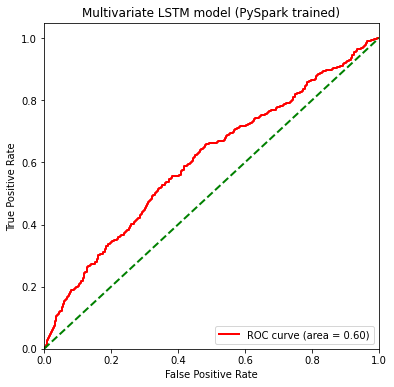

In [65]:
# Draw ROC-AUC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

fig = plt.figure()
fig.set_size_inches(6,6)

lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multivariate LSTM model (PySpark trained)')
plt.legend(loc="lower right")

# **Train LSTM model using GPU**

In [58]:
# train LSTM model using GPU
import tensorflow as tf
import timeit
np.random.RandomState(seed=66)
def gpu(X_train, y_train):
  with tf.device('/device:GPU:0'):

    # building LSTM model
    model = Sequential()
    model.add(Dense(input_shape=(timesteps, nb_features),units=300))
    #model.add(LSTM(input_shape=(timesteps, nb_features),units=100,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

    print(model.summary())
    model.fit(X_train, y_train, epochs=30, batch_size=200, validation_split=0.1, verbose=2)

    return model
lstm_model = gpu(X_train, y_train)
#gpu_time = timeit.timeit('gpu()', number=2, setup="from __main__ import gpu")
#print("GPU :",gpu_time)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 24, 300)           2100      
_________________________________________________________________
dropout_37 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 200)               400800    
_________________________________________________________________
dropout_38 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 201       
Total params: 403,101
Trainable params: 403,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 17486 samples, validate on 1943 samples
Epoch 1/30
 - 5s - loss: 0.7089 - accuracy: 0.5437 - val_lo

In [59]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc

# get test dataset
test= df[df.icustay_id.isin(id_test)]

X_test = (list(transform(test[test['icustay_id']==icustay_id], timesteps, features)) 
           for icustay_id in test['icustay_id'].unique())

X_test = np.concatenate(list(X_test)).astype(np.float32)


# generate labels
y_test = [labels(test[test['icustay_id']==icustay_id], timesteps, ['hospital_expire_flag']) 
             for icustay_id in test['icustay_id'].unique()]
y_test = np.concatenate(y_test).astype(np.float32)

# calculate y_pred and y_pred_proba
y_pred_proba = lstm_model.predict(X_test)
y_pred = lstm_model.predict_classes(X_test)
y_true = pd.DataFrame(y_test)

evaluate(y_true, y_pred, y_pred_proba)


Accuracy : 0.7424
AUC score : 0.6751

Classification report : 
               precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      2406
         1.0       0.23      0.46      0.31       346

    accuracy                           0.74      2752
   macro avg       0.57      0.62      0.58      2752
weighted avg       0.82      0.74      0.77      2752


Confusion matrix : 
 [[1884  522]
 [ 187  159]]


(0.7423691860465116, 0.6750560977133275)

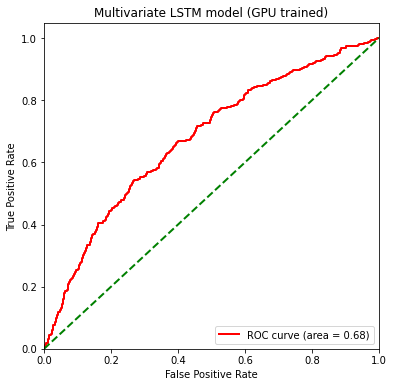

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

fig = plt.figure()
fig.set_size_inches(6,6)

lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multivariate LSTM model (GPU trained)')
plt.legend(loc="lower right")